<a href="https://colab.research.google.com/github/mkleshchenok/mlbookcamp-code/blob/master/course-zoomcamp/04-evaluation/hw-week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

Use this notebook as a starter

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-03 17:10:03--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.03s   

2021-10-03 17:10:04 (6.10 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [4]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [22]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(set(df.columns.values)-set(categorical_columns))
print(f'cat - {categorical_columns} \nnum - {numerical_columns}')

cat - ['home', 'marital', 'records', 'job'] 
num - ['seniority', 'age', 'default', 'income', 'price', 'assets', 'debt', 'time', 'expenses', 'amount']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [32]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [90]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, precision_recall_curve, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from collections import defaultdict

In [41]:
auc_per_column = defaultdict()

for c in ["seniority", "time", "income", "debt"]:    
    fpr, tpr, thresholds = roc_curve(y_train, df_train[c])
    auc_per_column[c]=auc(fpr, tpr)
    
print(auc_per_column)
print("Max is: ", max(auc_per_column.items(), key=lambda a: a[1]))

defaultdict(None, {'seniority': 0.2906221375508058, 'time': 0.5608662489595051, 'income': 0.31799333386736695, 'debt': 0.49521703242164505})
Max is:  ('time', 0.5608662489595051)


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [42]:
columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [43]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
round(auc(fpr, tpr),3)

0.818

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

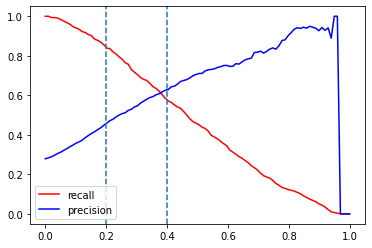

In [80]:
precision_scores=[]
recall_scores=[]

thresholds = np.linspace(0.0,1.0,100)
for threshold in thresholds:
    precision = precision_score(y_train, model.predict_proba(X_train)[:, 1] > threshold, zero_division=0)
    recall = recall_score(y_train, model.predict_proba(X_train)[:, 1] > threshold )
    precision_scores.append(precision)
    recall_scores.append(recall)

# print(precision_scores)
plt.plot(thresholds, recall_scores, color='red', label='recall')
plt.plot(thresholds, precision_scores, color='blue', label='precision')
plt.axvline(x=0.4, linestyle='--')
plt.axvline(x=0.2, linestyle='--')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

0.508
0.629
0.538
0.247


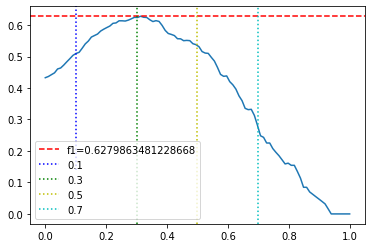

In [85]:
f1_scores = []

dv = DictVectorizer(sparse=False)
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

for threshold in thresholds:
    f1 = f1_score(y_val, model.predict_proba(X_val)[:, 1] > threshold)
    f1_scores.append(f1)
    
plt.plot(thresholds, f1_scores)
plt.axhline(max(f1_scores), linestyle='--', label=f'f1={max(f1_scores)}', color="r")
plt.axvline(0.1, ymax, linestyle='dotted', label=0.1, color='b')
plt.axvline(0.3, linestyle='dotted', label=0.3, color='g')
plt.axvline(0.5, linestyle='dotted', label=0.5, color='y')
plt.axvline(0.7, linestyle='dotted', label=0.7, color='c')

for t in [0.1,0.3,0.5,0.7]:
  print(round(f1_score(y_val, model.predict_proba(X_val)[:, 1] > t),3))
plt.legend()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [91]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
models = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train.default.values
    y_val = df_val.default.values
    X_train=df_train[columns]
    X_val = df_val[columns]
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    dicts = X_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model.fit(X_train, y_train)
    dicts_ = X_val.to_dict(orient='records')
    X = dv.transform(dicts_)
    y_pred = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    models.append(model)
round(np.std(scores),3)

0.014

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [96]:
for C in [0.01,0.1,1,10]:
  kfold = KFold(n_splits=5, shuffle=True, random_state=1)
  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  for train_idx, val_idx in kfold.split(df_full_train):
      df_train = df_full_train.iloc[train_idx]
      df_val = df_full_train.iloc[val_idx]
      y_train = df_train.default.values
      y_val = df_val.default.values
      X_train=df_train[columns]
      X_val = df_val[columns]
      dicts = X_train.to_dict(orient='records')
      dv = DictVectorizer(sparse=False)
      X_train = dv.fit_transform(dicts)
      model.fit(X_train, y_train)
      dicts_ = X_val.to_dict(orient='records')
      X = dv.transform(dicts_)
      y_pred = model.predict_proba(X)[:, 1]
      auc = roc_auc_score(y_val, y_pred)
      scores.append(auc)
      models.append(model)
  print(C, round(np.mean(scores),3), round(np.std(scores),3))

0.01 0.812 0.014
0.1 0.812 0.014
1 0.812 0.014
10 0.812 0.014


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.